In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Analysis of clusters in sample S3

In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

## Preprocessing
### Read data

In [3]:
data_path = "../../data/probe_Bac_scRNAseq_Rosenthal/MPA_energy_stress"
data_gene = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed.h5ad")


In [4]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

## Generate synthetic null data for ClusterDE

### Estimate distribution and parameters for every gene

In [5]:
importlib.reload(nb)
import warnings
warnings.filterwarnings("ignore")
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto")


gene 0
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 100
gene 200
Both NB and ZINB not converged! Using NB without starting params
gene 300
gene 400
Both NB and ZINB not converged! Using NB without starting params
gene 500
gene 600
Both NB and ZINB not converged! Using NB without starting params
gene 700
Both NB and ZINB not converged! Using NB without starting params
gene 800
gene 900
Both NB and ZINB not converged! Using NB without starting params
gene 1000
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 1100
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 1200
Both NB and ZINB not converged! Using NB without starting params
gene 1300
Both NB and ZINB not conver

In [6]:
data_gene.var

,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,...,dispersion_step1_sct,mean,std,gene_mean,gene_var,mean_var_diff,gene_dist,est_mean,est_overdisp,est_zero_inflation
Sr1,Gene Expression,PA01,9,0.001343,0.001342,99.865732,9.0,2.302585,9,0.001341,...,0.006108,-5.983806,0.209097,0.001343,0.001341,0.000002,poi,0.006286,inf,0.786152
aadK,Gene Expression,PA01,155,0.034611,0.034026,97.687603,232.0,5.451038,155,0.075186,...,0.189736,-4.473871,0.715206,0.034611,0.075186,-0.040574,nb,0.034622,0.031388,0.000000
aag,Gene Expression,PA01,18,0.003282,0.003277,99.731464,22.0,3.135494,18,0.005062,...,0.095260,-5.975305,0.311967,0.003282,0.005062,-0.001779,nb,0.003273,0.007842,0.000000
aapA,Gene Expression,PA01,65,0.013874,0.013779,99.030285,93.0,4.543295,65,0.029794,...,0.190042,-5.324951,0.545208,0.013874,0.029794,-0.015920,nb,0.013890,0.014487,0.000000
abbA,Gene Expression,PA01,285,0.066388,0.064277,95.748172,445.0,6.100319,285,0.153283,...,0.203239,-3.808319,0.848211,0.066388,0.153283,-0.086895,nb,0.066379,0.054379,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
znuB,Gene Expression,PA01,71,0.014322,0.014220,98.940773,96.0,4.574711,71,0.027245,...,NaN,-5.271061,0.565472,0.014322,0.027245,-0.012923,nb,0.014323,0.018721,0.000000
znuC,Gene Expression,PA01,21,0.003879,0.003871,99.686707,26.0,3.295837,21,0.005356,...,0.121542,-5.972178,0.344645,0.003879,0.005356,-0.001477,nb,0.003881,0.007600,0.000000
zosA,Gene Expression,PA01,319,0.069372,0.067071,95.240937,465.0,6.144186,319,0.144225,...,0.180779,-3.715182,0.873807,0.069372,0.144225,-0.074853,nb,0.069372,0.072423,0.000000
zur,Gene Expression,PA01,35,0.006415,0.006395,99.477846,43.0,3.784190,35,0.009358,...,NaN,-5.850591,0.429455,0.006415,0.009358,-0.002943,nb,0.006413,0.013254,0.000000


## Find optimal correlation matrix scaling and generate synthetic null data

In [7]:
importlib.reload(cd)
xmin, fval, R_est_noscale = cd.select_covariance_scaling(data_gene, cor_cutoff=0.1, min_scale=1, max_scale=2, maxiter=20, rng_seed=1234)
print(xmin)

Factor: 1 - Error: 0.22156492399825076
Factor: 2 - Error: 0.2219116746421478
Factor: -0.618034 - Error: 0.22251278770579347
Factor: 1 - Error: 0.22156492399825076
Factor: 0.38196600897566 - Error: 0.2226618605372871
Factor: 1.38196601 - Error: 0.14898267229403084
Factor: 1.6180339872046798 - Error: 0.2218965354512181
Factor: 1.2360679772046799 - Error: 0.22138536746800197
Factor: 1.4721359533416425 - Error: 0.14960743493455286
Factor: 1.3262379205463224 - Error: 0.14911099379056764
Factor: 1.4164078634801331 - Error: 0.14941548548347205
Factor: 1.3606797740264556 - Error: 0.14898258641430784
Factor: 1.3475241566756444 - Error: 0.14898272675981547
Factor: 1.3688103926491888 - Error: 0.14898256034898202
Factor: 1.373835391317765 - Error: 0.1489826356120521
Factor: 1.3657047726950315 - Error: 0.14898258620315946
Factor: 1.3707297713408801 - Error: 0.14898261176517125
Factor: 1.3676241513867229 - Error: 0.14898256171218943
Factor: 1.3695435300697332 - Error: 0.1489825885051248
Factor: 1.36

In [8]:
importlib.reload(cd)

# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)


In [9]:
importlib.reload(cd)
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True,
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False, min_nonzero=2)

In [10]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [11]:
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

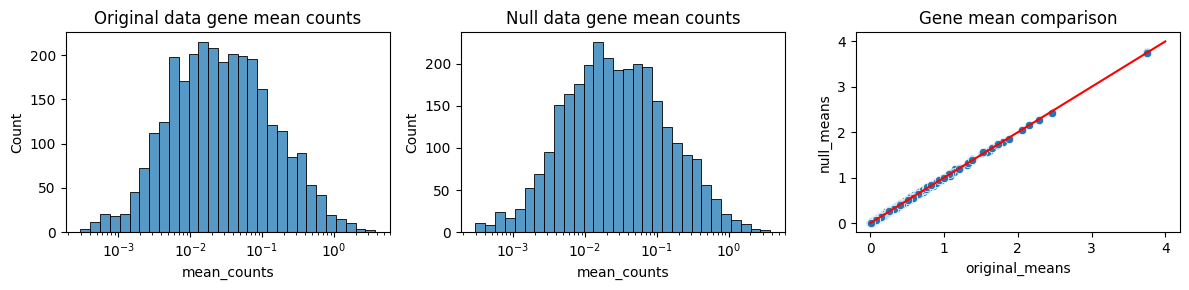

SignificanceResult(statistic=0.9964826544235383, pvalue=0.0)


In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene_nonzero.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

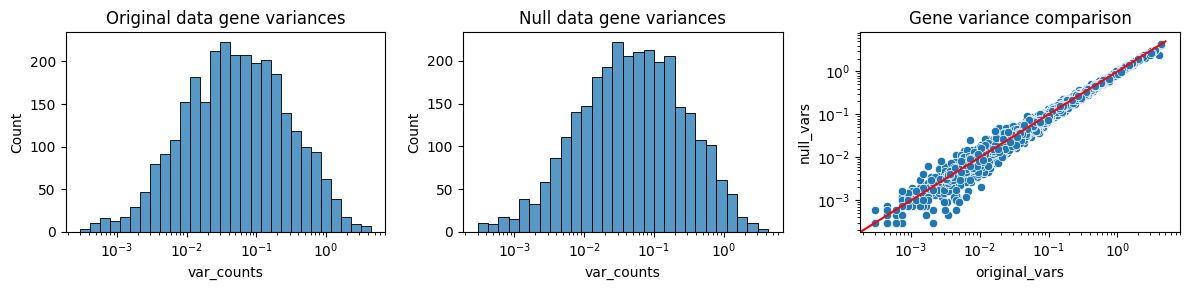

SignificanceResult(statistic=0.9912644392515598, pvalue=0.0)
[[1.         0.99474975]
 [0.99474975 1.        ]]


In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene_nonzero.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

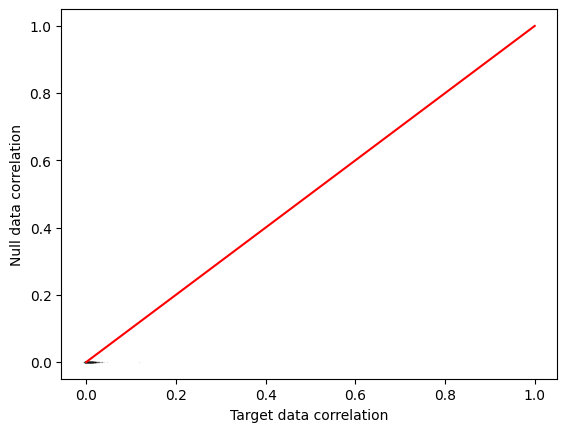

In [14]:
cor_shrink = cd.schaefer_strimmer(data_gene_nonzero.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1,
                color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_shrink']))], [0, np.ceil(np.max(all_cors_subset['cor_shrink']))],
         color="red")
plt.xlabel("Target data correlation")
plt.ylabel("Null data correlation")

plt.show()

### Process null data

In [15]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [16]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="sctransform")
data_null_gen.layers["counts"] = data_null_gen.X.copy()

k_opt = data_gene.uns["BacSC_params"]["k_opt"]
n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]
res_opt = data_gene.uns["BacSC_params"]["res_opt"]
print(n_neighbors_opt)

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


70


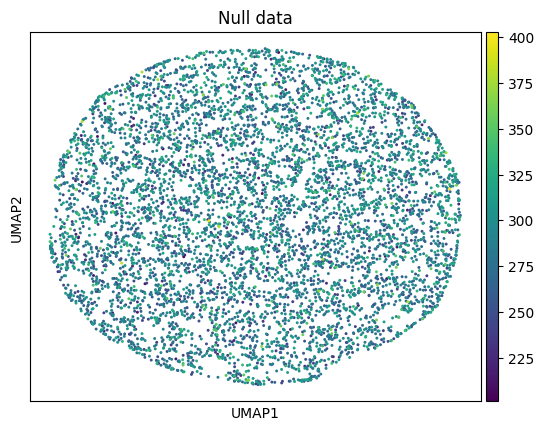

In [17]:
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()


In [18]:
data_null_gen.write(data_path + "/null_data_opt.h5ad")

In [19]:
res2 = 0.01
twoclust = False
#345 vs. 456

while twoclust is False:
    if (res2 * 100)%5 == 0:
        print(res2)
    res2 += 0.005
    res2 = np.round(res2, 3)
    sc.tl.leiden(data_null_gen, resolution=res2, key_added="leiden", random_state=234)
    nclust = len(data_null_gen.obs["leiden"].unique())
    if nclust == 2:
        twoclust = True
    
    
print(f"Resolution for two clusters: {res2}")

Resolution for two clusters: 0.03


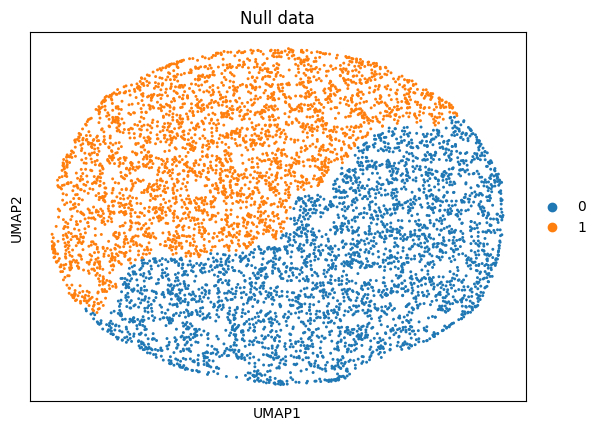

In [20]:
sc.pl.umap(data_null_gen, color="leiden", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [21]:
# data_null_gen.write("../../data/MOBA_scRNAseq/outs_S3/S3_null_data_opt.h5ad")


In [22]:
X_null_gen_0 = data_null_gen.X[data_null_gen.obs["leiden"] == "0"]
X_null_gen_1 = data_null_gen.X[data_null_gen.obs["leiden"] != "0"]

pval_null_gen = pd.DataFrame({"pval_null": ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue}, index=data_null_gen.var.index)

clusters = data_gene.obs["leiden_opt"].unique()

In [23]:
importlib.reload(cd)
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene_nonzero.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

Cluster 0 - DE genes: 35; Minimum q value: 0.02857142857142857
Cluster 2 - DE genes: 0; Minimum q value: 1.0
Cluster 3 - DE genes: 0; Minimum q value: 0.3333333333333333
Cluster 4 - DE genes: 175; Minimum q value: 0.010526315789473684
Cluster 1 - DE genes: 52; Minimum q value: 0.038461538461538464


In [24]:
DEs_gen = {}
pvals_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene_nonzero.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=False)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_gen[c] = DE_TU
    pvals_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_gen[c])}; Minimum q value: {np.min(pvals_gen[c]['q'])}")

Cluster 0 - DE genes: 0; Minimum q value: 0.21428571428571427
Cluster 2 - DE genes: 0; Minimum q value: 0.75
Cluster 3 - DE genes: 0; Minimum q value: 1.0
Cluster 4 - DE genes: 33; Minimum q value: 0.030303030303030304
Cluster 1 - DE genes: 68; Minimum q value: 0.02702702702702703


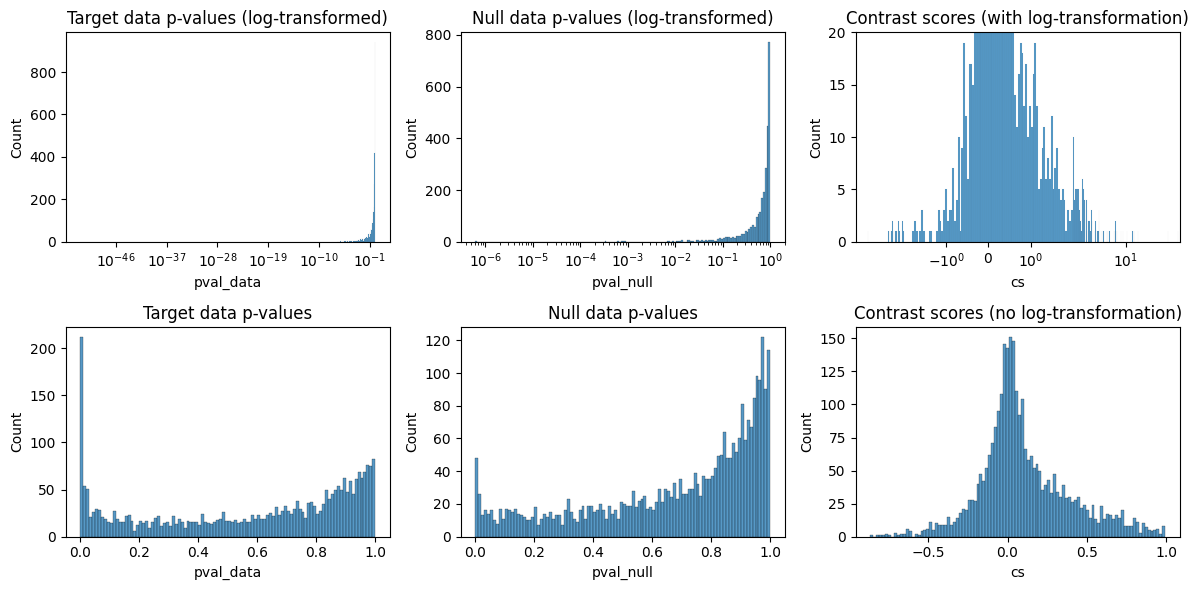

In [25]:
c = "1"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog",
            ylim=(0, 20)
            )

sns.histplot(pvals_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (no log-transformation)")


plt.tight_layout()
plt.show()

In [26]:
for c in clusters:
    print(f"cluster {c}")
    print(pvals_log_gen[c]["q"].value_counts().sort_index())
    print("")

cluster 0
0.028571      35
0.055556       1
0.078947       2
0.095238       4
0.113636       2
            ... 
0.993846       1
0.993902       6
0.993921       2
0.996983       5
1.000000    2261
Name: q, Length: 199, dtype: int64

cluster 2
1.0    2924
Name: q, dtype: int64

cluster 3
0.333333       3
0.750000       1
0.800000       1
1.000000    2919
Name: q, dtype: int64

cluster 4
0.010526     95
0.016949     23
0.025000      2
0.029197     17
0.036232      1
           ... 
0.436112      1
0.437377      1
0.437438      2
0.437561      4
1.000000    890
Name: q, Length: 418, dtype: int64

cluster 1
0.038462      52
0.054545       3
0.066667       5
0.078125       4
0.084507       7
            ... 
0.606530       3
0.606748       1
0.606965       1
0.608026      10
1.000000    1105
Name: q, Length: 396, dtype: int64



In [27]:
pvals_log_gen[("3")]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
srfAD,7.273763e-11,6.248690e-01,10.138241,0.204211,9.934030,0.333333
srfAC,9.756016e-07,7.136540e-01,6.010727,0.146512,5.864215,0.333333
srfAB,7.675467e-07,1.759371e-01,6.114895,0.754643,5.360253,0.333333
yydF,1.813758e-05,4.968735e-01,4.741421,0.303754,4.437666,0.750000
disA,8.842679e-06,1.438532e-01,5.053416,0.842080,4.211336,0.800000
...,...,...,...,...,...,...
yqeZ,8.866941e-03,6.685079e-07,2.052226,6.174893,-4.122667,1.000000
atpG,9.012647e-01,5.751858e-05,0.045148,4.240192,-4.195044,1.000000
mntC,2.282817e-01,1.315180e-05,0.641529,4.881015,-4.239486,1.000000
fbaA,6.753662e-02,1.788895e-06,1.170461,5.747415,-4.576954,1.000000
